In [1]:
# import and set options
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils

## P-value distribution

In this notebook we examine the p-value distribution of cancer driver gene prediction methods. The divergence of p-values from the expected null uniform distribution can indicate problematic assumptions in a model. We first quantify this divergence through the mean log fold change (MLFC) metric, and, second, graphically examine through a qq plot.  

### Load data

The first step is to load in the p-values for each method. Since it only makes sense to compare the p-value distribution under the null hypothesis, we remove genes which are significant from 3 cases and those found in the Cancer Gene Census (CGC). After this filtering step, we assume the substantial majority of remaining genes reflect passenger genes.  

In [ ]:
# load config
config = utils.load_config('config.yaml')

# get full data for each method
full_data = utils.fetch_filtered_dataframes('example_data/pancan',  # input data containing directory
                                            'output',  # output directory
                                            3,  # filter genes with 3 methods agreeing
                                            'CGC-freeze-download-date-20160401.tsv')  # filter cancer gene census genes

### Mean log fold change (MLFC)

The following functions compute the mean absolute log2 fold change for the p-value distribution compared to the expected uniform distribution under the null hypothesis. We define $P(i)$ = i'th smallest p-value and $q(i) = \frac{i}{n}$, then

$$MLFC = \frac{1}{n}\sum^n_{i=1}\left|log_2\frac{P(i)}{q(i)}\right|$$

where P represents the observed p-value, q is the corresponding expected p-value from a uniform distribution, n is the total number of genes, and MLFC is the average difference of observed and theoretical p-values. Values of MLFC near zero indicate smaller discrepancies, and therefore better statistical modeling of the passenger gene null distribution.

In [2]:
def mean_log_fold_change(data):
    """Mean log fold change function
    
    Parameters
    ----------
    data : pd.Series
        a series of p-values
    
    Returns
    -------
    mlfc : float
        mean log fold change.
    """
    tmp = data.copy()
    tmp.sort_values(ascending=True, inplace=True)
    tmp[tmp==0] = tmp[tmp>0].min()  # avoid infinity in log by avoiding zero pvals
    dist_quant = np.arange(1, len(tmp)+1)/float(len(tmp))
    mlfc = np.mean(np.abs(np.log2(tmp/dist_quant)))
    return mlfc

def compute_mlfc(df, meth_name, config):
    """Convenience function to compute mean log fold change from data frame for each method.
    
    This is a convenience wrapper to compute the mean log fold change directly
    from the result output for each method. It uses a configuration file
    to correctly parse which columns hold the p-values.
    
    Parameters
    ----------
    df : pd.DataFrame
        data frame containing p-value column
    meth_name : str
        method name for the data frame, should match the config file
    config : dict
        yaml config file loaded as a dictionary
    
    Returns
    -------
    mean_mlfc : float
        mean log fold change for method
    """
    # check whether there is custom p-value columns
    if utils.is_valid_config(config, meth_name, 'pvalue'):
        pval_cols = config[meth_name]['pvalue']
    else:
        pval_cols = ['pvalue']

    # calculate the mlfc scores for each pvalue column
    mlfc_score_list = []
    for pval_col in pval_cols:
        pvals = df[pval_col].dropna().copy()
        tmp_score = mean_log_fold_change(pvals)
        mlfc_score_list.append(tmp_score)

    # calculate the mean score, if multiple values
    mean_mlfc = np.mean(mlfc_score_list)

    return mean_mlfc

### Compute MLFC scores

Next, we will compute the MLFC scores for each method

In [48]:
# compute MLFC scores
mlfc_result = {m: compute_mlfc(full_data[m], m, config)
               for m in full_data}
mlfc_series = pd.Series(mlfc_result)
mlfc_series

2020+             0.138615
ActiveDriver      1.242893
MuSiC             2.564325
MutsigCV          1.152682
OncodriveClust    1.476567
OncodriveFM       1.747076
OncodriveFML      0.860177
TUSON             0.740439
dtype: float64

### Plot results

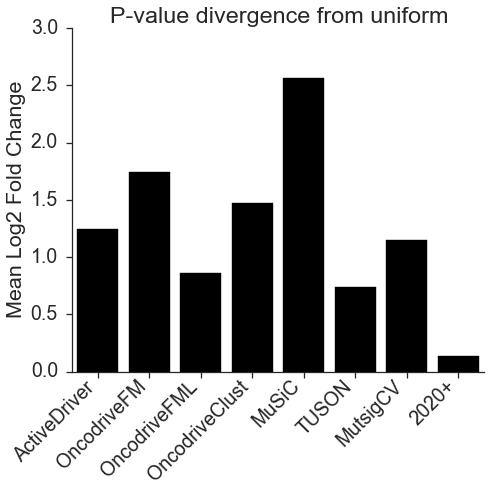

In [53]:
def plot_mlfc_score(mlfc, custom_order=None):
    """Bar plot of MLFC scores.
    
    Params
    ------
    mlfc : pd.Series
        pandas series containing MLFC scores
    custom_oder : list or None
        custom order for methods in bar plot
    """
    # order mlfc values
    if custom_order is None:
        mlfc.sort_values(inplace=True, ascending=False)
    else:
        mlfc = mlfc[custom_order]
        
    # make mlfc bar plot
    with sns.axes_style('ticks'), sns.plotting_context('talk', font_scale=1.5):
        sns.barplot(mlfc.index, mlfc, color='black')
        sns.despine()
        plt.gca().set_xticklabels(mlfc.index, rotation=45, ha='right')
        plt.ylabel('Mean Log2 Fold Change')
        plt.gcf().set_size_inches(7, 7)
        plt.gca().tick_params(axis='x', which='major', pad=0)
        plt.title('P-value divergence from uniform')

    plt.tight_layout()

order = ['ActiveDriver', 'OncodriveFM', 'OncodriveFML', 
         'OncodriveClust', 'MuSiC', 'TUSON', 'MutsigCV', '2020+']
plot_mlfc_score(mlfc_series, custom_order=order)

## QQ plot

A q-q plot is a graphical way to examine two distributions. In this case we compare the p-value distribution to the expected uniform distribution. We plot the p-values as a blue line, while a perfect uniform distribution is the red line.

The following `qqplot` function creates a p-value qq-plot with that expected from a uniform distribution. As input it takes a pandas series object of p-values for a method.

In [50]:
def qqplot(data, 
           ax=None, 
           log=False, title=None, 
           use_xlabel=True, use_ylabel=True, 
           **kwargs):
    """Function for qq-plot with uniform distribution.
    
    Parameters
    ----------
    data : pd.Series
        p-values from each method
    
    """
    # sort p-values
    tmp = data.copy()
    tmp.sort_values(inplace=True)
    
    # expected p-values
    dist_quant = np.arange(1, len(tmp)+1)/float(len(tmp)+1)
    if log:
        log_quant = -np.log10(dist_quant)
        if ax is None:
            plt.plot(log_quant, -np.log10(tmp),'o', markersize=3, **kwargs)
            plt.plot([0, log_quant[0]], [0, log_quant[0]], ls="-", color='red')
        else:
            ax.plot(log_quant, -np.log10(tmp),'o', markersize=3, **kwargs)
            ax.plot([0, log_quant[0]], [0, log_quant[0]], ls="-", color='red')
        # set axis labels
        if use_xlabel:
            if ax is None: plt.xlabel('Theoretical ($-log_{10}(p)$)')
            else: ax.set_xlabel('Theoretical ($-log_{10}(p)$)')
        if use_ylabel:
            if ax is None: plt.ylabel('Observed ($-log_{10}(p)$)')
            else: ax.set_ylabel('Observed ($-log_{10}(p)$)')
    else:
        if ax is None:
            plt.plot(dist_quant, tmp,'o', markersize=3, **kwargs)
            plt.plot([0, 1], [0, 1], ls="-", color='red')
        else:
            ax.plot(dist_quant, tmp,'o', markersize=3, **kwargs)
            ax.plot([0, 1], [0, 1], ls="-", color='red')
            ax.set_ylabel('p-value')
        if use_xlabel:
            if ax is None: plt.xlabel('Theoretical Quantile')
            else: ax.set_xlabel('Theoretical Quantile')
        if use_ylabel:
            if ax is None: plt.ylabel('Observed Quantile')
            else: ax.set_ylabel('Observed Quantile')
    if title:
        ax.set_title(title)
    sns.despine()
    
def set_axes_label(fig, xlab, ylab, 
                   ylab_yoffset=.55, ylab_xoffset=0.04,
                   xlab_yoffset=.04, xlab_xoffset=0.5):
    """Function to modify the axis labels for the qq plot"""
    txt1 = fig.text(xlab_xoffset, xlab_yoffset, xlab, ha='center', size=22)
    txt2 = fig.text(ylab_xoffset, ylab_yoffset, ylab, ha='center', size=22, rotation=90)
    return txt1, txt2

def get_pvalues(df, meth_name, config):
    """Convenience function to get correct column for p-values.
    
    Parameters
    ----------
    df : pd.DataFrame
        data frame containing p-value column
    meth_name : str
        method name for the data frame, should match the config file
    config : dict
        yaml config file loaded as a dictionary
    
    Returns
    -------
    pval_df_list : list
        list of data frames with pvalue column
    """
    # check whether there is custom p-value columns
    if utils.is_valid_config(config, meth_name, 'pvalue'):
        pval_cols = config[meth_name]['pvalue']
    else:
        pval_cols = ['pvalue']

    # data frames for p-values of each method
    pval_df_list = []
    for pval_col in pval_cols:
        # get p-values
        pvals = df[pval_col].dropna().copy()
        
        # make a new formatted df
        tmp_df = pd.DataFrame({'pvalue': pvals, 'method': meth_name + ' ' + pval_col})
        pval_df_list.append(tmp_df)

    return pval_df_list

We first format the data for making the qq plots. We put the p-values into a tidy data frame with one column containing all the p-values and the second column containing the corresponding method which generated that p-value.

In [51]:
# merge all the p-value info for each method into a single data frame
data_list = []
for m in full_data:
    data_list.extend(get_pvalues(full_data[m], m, config))
pvalue_df = pd.concat(data_list)

# format the names
rename_dict = {'TUSON TUSON.combined.pvalue.TSG': 'TUSON TSG', 'TUSON TUSON.combined.pvalue.OG': 'TUSON OG',
               'ActiveDriver pvalue': 'ActiveDriver', 'OncodriveClust pvalue': 'OncodriveClust',
               'MuSiC pvalue': 'MuSiC', 'OncodriveFML pvalue': 'OncodriveFML',
               'OncodriveFM pvalue': 'OncodriveFM', '2020+ driver p-value': '20/20+',
               'MutsigCV pvalue': 'MutsigCV'}
pvalue_df['method'] = pvalue_df.method.replace(rename_dict)

# show the data frame
pvalue_df.head()

,method,pvalue
0,ActiveDriver,0.029069
1,ActiveDriver,0.021281
2,ActiveDriver,1.000000
3,ActiveDriver,1.000000
4,ActiveDriver,1.000000


Using the `qqplot` function, we make a panel of qq plots for each method's p-values.

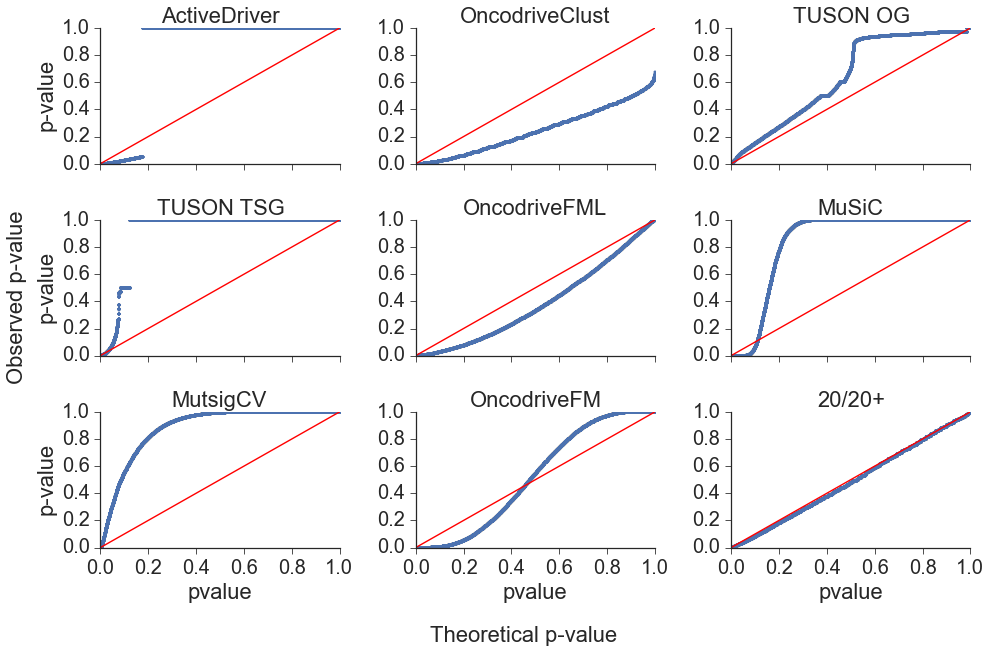

In [52]:
# make qq plots
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=2.5):
    g = sns.FacetGrid(pvalue_df, col="method", col_wrap=3, sharey=False, aspect=1.5)
    g.map(qqplot, "pvalue")
    plt.tight_layout()
    txt_tuple = set_axes_label(g.fig, 'Theoretical p-value', 'Observed p-value', 
                               ylab_xoffset=-0.02, ylab_yoffset=.62, xlab_yoffset=-0.02)
    g.set_titles('{col_name}')
    
    # set ylabel
    g.axes[0].set_ylabel('p-value')
    g.axes[3].set_ylabel('p-value')
    g.axes[6].set_ylabel('p-value')
    
    # set xlim, change limits to focus
    # on different regions
    for myax in g.axes:
        myax.set_xlim((0, 1))
        myax.set_ylim((0, 1))